# Feature generation: turning texts into numbers

Practical course material for the ASDM Class 09 (Text Mining) by Florian Leitner.

© 2016 Florian Leitner. All rights reserved.

Today's lab will cover advanced techniques to prepare your text: CFDs, Huffman coding, and word embeddings.

In [1]:
%pylab inline --no-import-all
pylab.rcParams['figure.figsize'] = (12, 7)

Populating the interactive namespace from numpy and matplotlib


Today we also will be using [gensim](https://radimrehurek.com/gensim/index.html); Please make sure you have it installed (if not: ` conda install gensim ` or ` pip3 install gensim ` will get it done).

In [2]:
import gensim
import nltk
from nltk.book import text1
from nltk.book import text7 as wsj
from nltk.book import FreqDist
alice = nltk.data.load('corpora/gutenberg/carroll-alice.txt', format='text')

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


## Bag-of-words

To work with texts using "numerical recipies" we need to encode the text into some vector space. The most straight-forward way to encode a text as a point (i.e., an _instance_) in some n-dimensional space is to treat each unique token in our entire corpus as its own dimension in that space (i.e., a _feature_). Then, we can use the number of times (commonly [and maybe poorly] named the _frequency_ of) a token appears in a particular text (instance) in our corpus as the size of the instance' vector on that dimension.

Let's assume we want to convert books into vectors we wish to classify. So we simply count all words and convert that into a long vector (a.k.a., _frequency distribution_):

In [3]:
fdist1 = FreqDist(text1)
print(", ".join("'%s': %d" % i for i in fdist1.most_common(70)))

',': 18713, 'the': 13721, '.': 6862, 'of': 6536, 'and': 6024, 'a': 4569, 'to': 4542, ';': 4072, 'in': 3916, 'that': 2982, ''': 2684, '-': 2552, 'his': 2459, 'it': 2209, 'I': 2124, 's': 1739, 'is': 1695, 'he': 1661, 'with': 1659, 'was': 1632, 'as': 1620, '"': 1478, 'all': 1462, 'for': 1414, 'this': 1280, '!': 1269, 'at': 1231, 'by': 1137, 'but': 1113, 'not': 1103, '--': 1070, 'him': 1058, 'from': 1052, 'be': 1030, 'on': 1005, 'so': 918, 'whale': 906, 'one': 889, 'you': 841, 'had': 767, 'have': 760, 'there': 715, 'But': 705, 'or': 697, 'were': 680, 'now': 646, 'which': 640, '?': 637, 'me': 627, 'like': 624, 'The': 612, 'their': 612, 'are': 586, 'they': 586, 'an': 582, 'some': 578, 'then': 571, 'my': 564, 'when': 553, 'upon': 538, 'out': 529, 'into': 520, 'man': 508, 'ship': 507, 'up': 505, 'Ahab': 501, 'more': 501, '."': 489, 'no': 484, 'them': 471


That is, with the help of `FreqDist`, We just created a word vector from the tokens in `text1`. 

In [4]:
help(fdist1)

Help on FreqDist in module nltk.probability object:

class FreqDist(collections.Counter)
 |  A frequency distribution for the outcomes of an experiment.  A
 |  frequency distribution records the number of times each outcome of
 |  an experiment has occurred.  For example, a frequency distribution
 |  could be used to record the frequency of each word type in a
 |  document.  Formally, a frequency distribution can be defined as a
 |  function mapping from each sample to the number of times that
 |  sample occurred as an outcome.
 |  
 |  Frequency distributions are generally constructed by running a
 |  number of experiments, and incrementing the count for a sample
 |  every time it is an outcome of an experiment.  For example, the
 |  following code will produce a frequency distribution that encodes
 |  how often each word occurs in a text:
 |  
 |      >>> from nltk.tokenize import word_tokenize
 |      >>> from nltk.probability import FreqDist
 |      >>> sent = 'This is an example s

However, around the 70 most frequent tokens account for half of all words in the corpus, with just *seven* words making up nearly one quarter of all tokens in this text (',', 'the', '.', 'of', 'and', 'a', and 'to')!

total: 260819


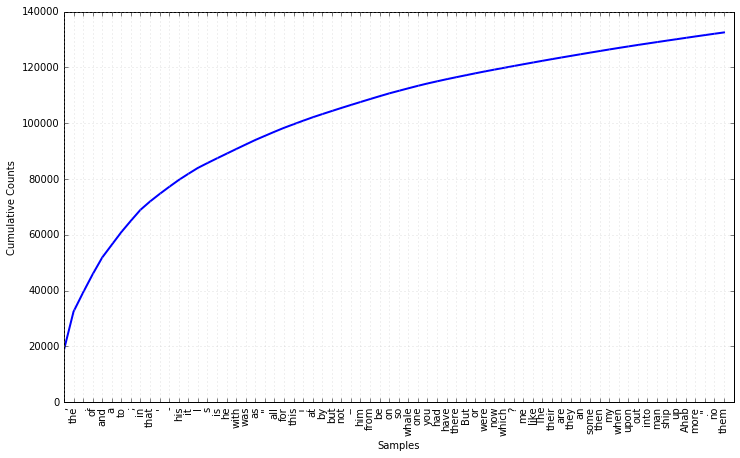

In [5]:
print("total:", fdist1.N())
fdist1.plot(70, cumulative=True)

The number of unique tokens in `fdist1` then is the the dimensionality of our vector space:

In [6]:
fdist1.B()

19317

However, of all those tokens, nearly half only occur once; Such tokens are called "[hapax legomenons](https://en.wikipedia.org/wiki/Hapax_legomenon)", or, colloquially, simply "hapaxes":

In [7]:
len(fdist1.hapaxes())

9002

By extension, this means if we'd create a bag-of-word vector with possibly hundreds of thousands of tokens from all the books we are about to classify, most tokens would hardly ever be observed in any book but one.

To lessen that impact, we can filter out words with extremely low frequency, e.g. drop tokens (dimensions) from the final vector space that we use. But even then, these vectors will be extremely sparse, as can be deduced from the CFD plot above. And sparse vectors in turn can be a problem with many Machine Learning techniques, as we discussed in class.

## Langauge models

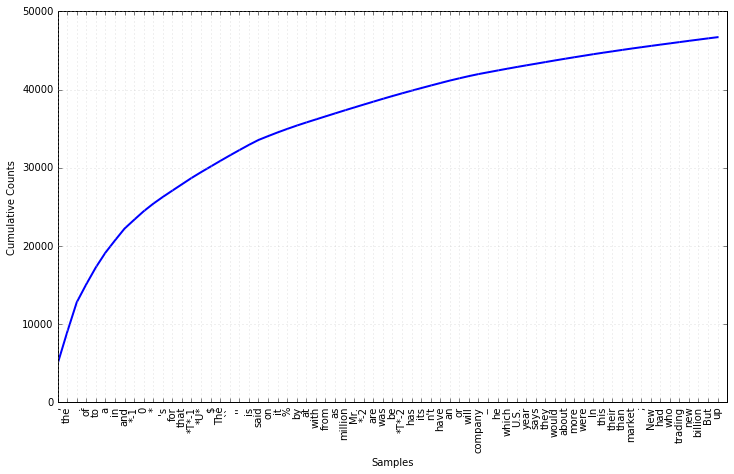

In [8]:
fdistWsj = FreqDist(wsj)
fdistWsj.plot(70, cumulative=True)

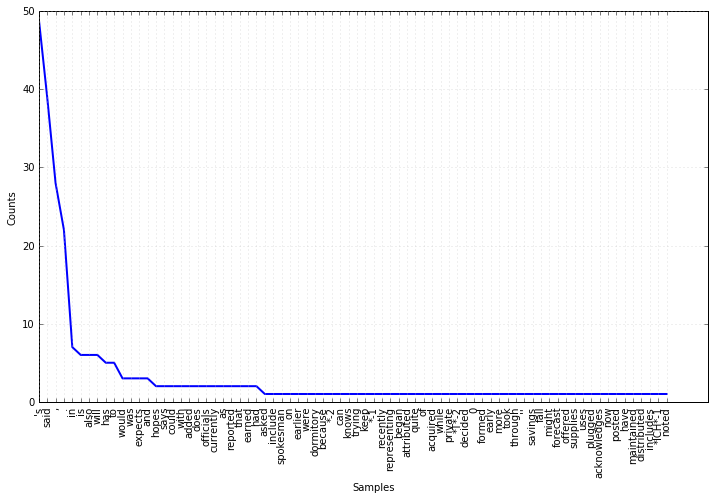

In [9]:
from nltk import ConditionalFreqDist as CFD
bigramDist = CFD(nltk.bigrams(wsj))
bigramDist['company'].plot()

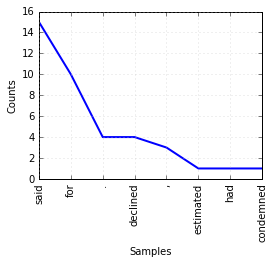

In [10]:
plt.figure(figsize=(4, 3))
bigramDist['spokesman'].plot()

It almost seems as if its the spokesmen is doing the negative sentiment speeches (condemned, declined) and "the company" announces things when the outlook is more positive (expects, hopes).

In [11]:
bigramDist.tabulate(conditions=['company', 'spokesman'],
                    samples=["condemned", "declined", "estimated", "expects", "hopes", "reported", "said", "says"])

          condemned  declined estimated   expects     hopes  reported      said      says 
  company         0         0         0         3         2         2        39         2 
spokesman         1         4         1         0         0         0        15         0 


Due to how we are building these frequency models from observed n-gram probabilities, we say we have a *generative* model that allows us to _generate language_. And by combining that model with a random number generator, even can even generate language non-deterministically.

In [12]:
def generate_model(cfdist, word, num=10):
    for i in range(num):
        print(word, end=' ')
        word = cfdist[word].max()

In [13]:
generate_model(bigramDist, 'the', 11)

the company 's a share , the company 's a share 

In [14]:
import random

def generate_model(cfdist, word, num=10, prefix=""):
    print(prefix, end='')
    for i in range(num):
        print(word, end=' ')
        # word = cfdist[word].max()
        word = random.choice(list(cfdist[word].elements()))

In [18]:
generate_model(bigramDist, 'company', prefix="The ")

The company , triple the firm . The July , trying 

To build better models then, we just increase the n-gram sizes (models with 5-grams do exist); But the longer the token sequence for the modeling gets, the smaller the samples we can work with will be. I.e., most grammatically correct, possible 5-grams will only be observed in very few texts out of *all* of humanty's "text corpus".

So just as with the Bag-of-Words, how can we create reliable, statistical (language or sequence) models for any of the less frequent tokens if we only have very few or just one exmple to learn from in those cases?

## Word embeddings

Word embeddings are a way to convert these high-dimensional, sparse vectors we have seen so far into low-dimensional, dense ones.

For example, we can use the "neural embedding" technique to compute (factorize) compact M-dimensional vectors from N-dimensional input vectors.

In [22]:
from gensim.models import Word2Vec
#Word2Vec?
help(Word2Vec)

Help on class Word2Vec in module gensim.models.word2vec:

class Word2Vec(gensim.utils.SaveLoad)
 |  Class for training, using and evaluating neural networks described in https://code.google.com/p/word2vec/
 |  
 |  The model can be stored/loaded via its `save()` and `load()` methods, or stored/loaded in a format
 |  compatible with the original word2vec implementation via `save_word2vec_format()` and `load_word2vec_format()`.
 |  
 |  Method resolution order:
 |      Word2Vec
 |      gensim.utils.SaveLoad
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, word)
 |  
 |  __getitem__(self, words)
 |      Accept a single word or a list of words as input.
 |      
 |      If a single word: returns the word's representations in vector space, as
 |      a 1D numpy array.
 |      
 |      Multiple words: return the words' representations in vector space, as a
 |      2d numpy array: #words x #vector_size. Matrix rows are in the same order
 |      as in input.
 

In [20]:
sentences = [['first', 'sentence'], ['second', 'sentence']]
# train word2vec on the two sentences
model = Word2Vec(sentences, min_count=1)

In [21]:
model.layer1_size

100

In [23]:
from nltk.corpus import gutenberg

In [24]:
from segtok.segmenter import split_multi
from segtok.tokenizer import word_tokenizer, split_contractions
model = Word2Vec(gutenberg.sents(), min_count=1)

In [25]:
fdistGuten = FreqDist(gutenberg.words())

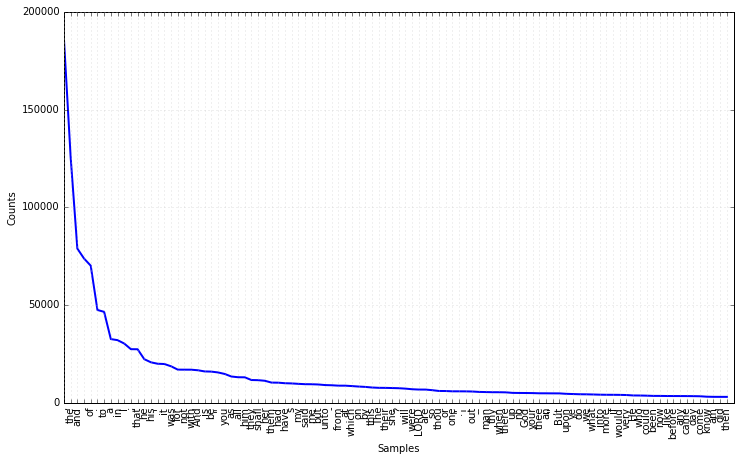

In [26]:
fdistGuten.plot(100)

In [ ]:
#Word2Vec??

In [27]:
model.most_similar(positive=['men', 'women'], negative=['lords'])

[('those', 0.6966253519058228),
 ('ladies', 0.6310247778892517),
 ('these', 0.5610675811767578),
 ('bucks', 0.5523515343666077),
 ('grayheaded', 0.5456365346908569),
 ('Toes', 0.5431016683578491),
 ('whales', 0.5381720066070557),
 ('cherrying', 0.5379135608673096),
 ('themselves', 0.5377594232559204),
 ('Few', 0.5342890024185181)]

The vector for `LORD` - describing the Lord in 100 numbers:

In [28]:
model['LORD']

array([ 0.68791187, -1.88462377,  3.4150393 , -1.69621503, -2.22791481,
       -2.94889808, -2.47657657,  1.8516047 , -1.20458269,  0.36664093,
        0.36904779, -2.30321574,  2.53771067, -1.66825974, -0.76388514,
       -0.46452612,  1.31762159, -1.30209255, -0.92840862, -0.89835531,
        0.34494525,  3.26609588,  0.0184846 , -0.2558327 ,  2.85018563,
       -0.87229282, -3.29423618, -1.49070811, -1.04286098,  1.72652853,
        1.17295122, -1.40627742, -1.49732137,  0.58994657, -1.1212765 ,
        1.60475826, -0.43447998,  0.91982514, -1.27660525, -1.74253392,
        1.77091789,  1.26288402, -1.25622249,  1.8313483 , -0.86169857,
       -1.9963876 ,  0.23570418,  0.40859446, -1.43627179, -0.67267138,
        3.52058053, -0.20684609, -1.01973617, -0.31176957,  3.28724742,
       -0.85344297, -1.39938569, -2.18525791,  0.94752914,  2.49917388,
       -1.4641062 ,  1.11076713, -4.19471264, -1.27103591, -4.10302162,
        1.23393714, -3.24661851, -0.66071904, -1.97085738, -0.73

Conclusion: Word embeddings represent a way to transition from sparse, discrete count vectors to dense, continuous "semantic" vectors.

In real-world NLP applications, you might have a huge collection of text, but only a tiny fraction of annotated data for your NLP system to "learn" from. By first developing word embeddings on the huge collection, you can transfer some of the "wisdom" in that collection to the system you are training on a much smaller fraction. That way, you can still hope that your final system will behave well when encountering text as found in the huge collection, but not the small collection it was trained on.